# How to count and select coins from a given image

Analyzing input image WhiteBackground/P70127-164819.jpg


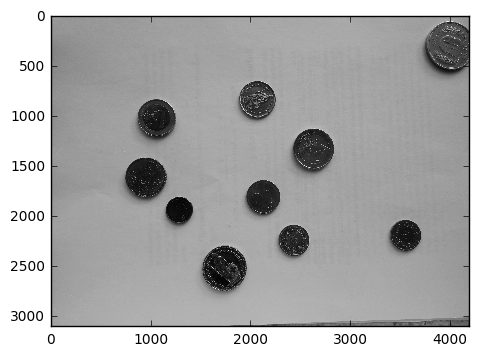

(3104, 4192, 3)


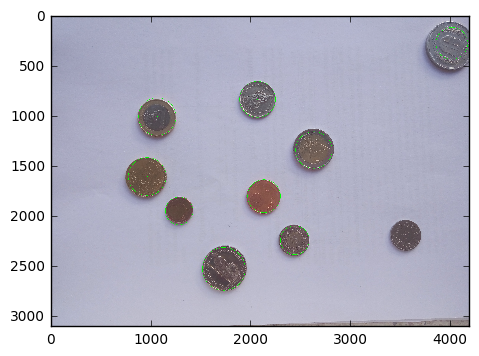

Total number of circles 9
(3104, 4192, 3)


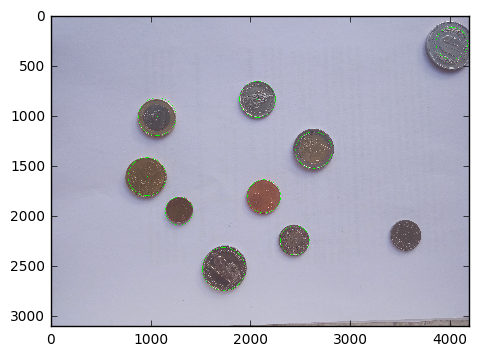

[1728 2534  214]
2256 2812 1450 2006


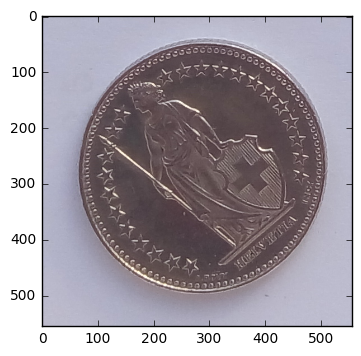

[2066  842  181]
607 1077 1831 2301


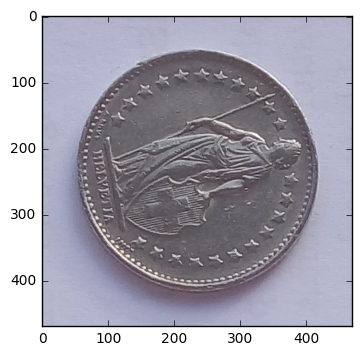

[2630 1348  183]
1111 1585 2393 2867


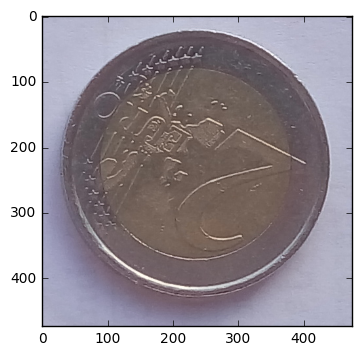

[4010  282  159]
76 488 3804 4192


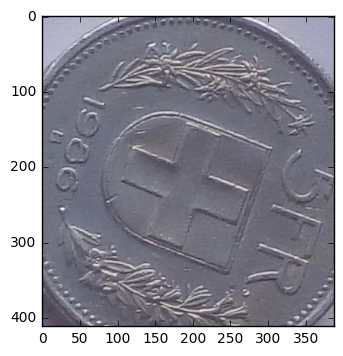

[2440 2248  145]
2060 2436 2252 2628


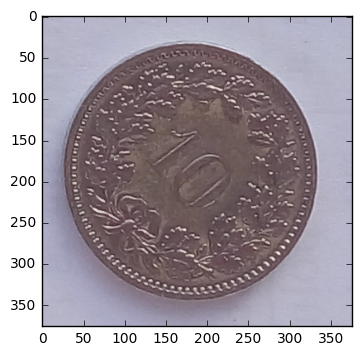

[2132 1808  166]
1593 2023 1917 2347


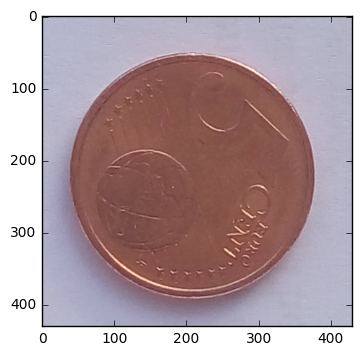

[1064 1014  188]
770 1258 820 1308


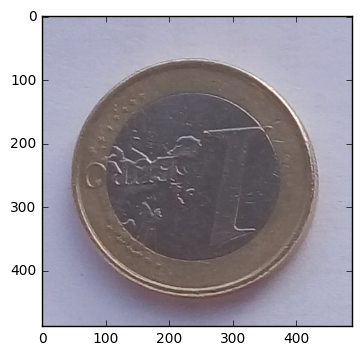

[ 962 1612  190]
1365 1859 715 1209


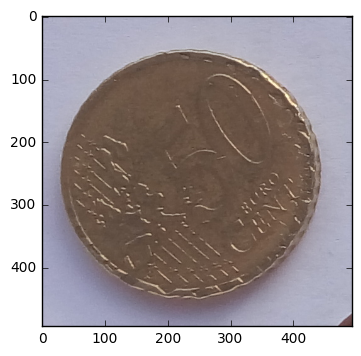

[1282 1956  139]
1776 2136 1102 1462


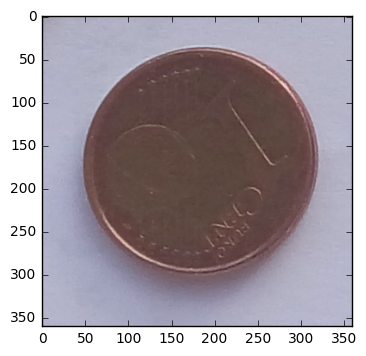

In [1]:
from PIL import Image
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import copy

def showInformation(img):
    print img.shape #dimensions of input image
    plt.imshow(img)
    plt.show()

def applyFilters(channel):#Not used....

    channel = cv2.adaptiveThreshold(channel, 255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,2)
    #mop up the dirt
    channel = cv2.dilate(channel, None, 1)
    channel = cv2.erode(channel, None, 1) 

    return channel

def preProcessing(img):#Not used....
    # create tmp images
    processed = copy.deepcopy(img)
    b,g,r = cv2.split(img)

    #process each component
    b = applyFilters(b)
    g = applyFilters(g)
    r = applyFilters(r)

    processed = cv2.merge((b,g,r))

    return processed

def inter_centre_distance(x1,y1,x2,y2):
    return ((x1-x2)**2 + (y1-y2)**2)**0.5

def colliding_circles(circles):
    for i in circles[0,:]:
        for j in circles[0,:]:
            x1, y1, Radius1 = i
            x2, y2, Radius2 = j
            if i[0] == j[0] and i[1] == j[1]:
                continue ## looking at the same circle
                
            #collision or containment:
            #print inter_centre_distance(x1,y1,x2,y2), Radius1, Radius2
            if inter_centre_distance(x1,y1,x2,y2) < (Radius1 + Radius2)*0.95:
                print "Warning: There are colliding circles "+str(len(circles[0,:]))
                return True


def drawCircles(img,circles):
    cimg=copy.deepcopy(img)
    for i in circles[0,:]:
        # draw the outer circle
        cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
        # draw the center of the circle
        cv2.circle(cimg,(i[0],i[1]),2,(0,255,0),3)
    return cimg
            
def findCircles(img, param1=100, param2=100):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    gray = cv2.dilate(gray, None, 1)
    gray = cv2.erode(gray, None, 1) 
    
    plt.imshow(gray, cmap='gray')
    plt.show()

    try:
        circles = cv2.HoughCircles(gray,cv2.HOUGH_GRADIENT,0.01,250, param1=param1, param2=param2)
        showInformation(drawCircles(imarray, circles))
    except:
        param2=int(param2/2) # largely reduce par2 to ensure convervence
        circles = cv2.HoughCircles(gray,cv2.HOUGH_GRADIENT,0.01,250, param1=param1, param2=param2)
        
    #Suspect that I miss circles
    while len(circles[0,:]) in range(0,6) and param2>=70: 
        param2 = param2 -5
        #twice the separation to reduce fakes
        circles = cv2.HoughCircles(gray,cv2.HOUGH_GRADIENT,0.01,250, param1=param1, param2=param2) 
        
    #Suspect that I have too many circles
    while colliding_circles(circles) == True:
        step = 1
        if len(circles[0,:]) > 12:
            step = 2
        if len(circles[0,:]) > 15:
            step = 5
        if len(circles[0,:]) > 20:
            step = 10
        param2 = param2 +step
        print "Trying para2... "+str(param2)
        circles = cv2.HoughCircles(gray,cv2.HOUGH_GRADIENT,0.01,250, param1=param1, param2=param2)

    ncircles = len(circles[0,:])
    #Decrease the criteria to built a circle (at the risk of getting fakes) when low number of circles found.

    circles = np.uint16(np.around(circles))
    print "Total number of circles "+str(len(circles[0,:]))
    return circles

def showCandidates(img,circles):
    candidates = []
    for i in circles[0,:]:
        print i 
        xcenter = i[1]
        ycenter = i[0]
        radius = i[2] 
        radius_ext = int(radius*1.30) # extend the radius by 15% to get border of coin
        xmin = max(0, xcenter-radius_ext)
        xmax = min(img.shape[0], xcenter+radius_ext)
        ymin = max(0, ycenter-radius_ext)
        ymax = min(img.shape[1], ycenter+radius_ext)
        print xmin, xmax, ymin, ymax
        plt.imshow(img[xmin:xmax, ymin:ymax])
        plt.show()
        candidates.append(img[xmin:xmax, ymin:ymax])
    return candidates

def saveCandidates(outputfolder, source, candidates):
    print "Saving Coins"
    output_filename = outputfolder+source.split("/")[-1].split(".")[0]+"_Candidate_"
    for index, i in enumerate(candidates):
        #print index, i.shape
        img = Image.fromarray(i, 'RGB')
        img.save(output_filename+str(index+1)+".jpg")
    return 0

def saveCircles(outputfolder, source, cimg):
    print "Saving Circles"
    output_filename = outputfolder+source.split("/")[-1].split(".")[0]+"_Circles"
    plt.imshow(cimg)
    img = Image.fromarray(cimg, 'RGB')
    img.save(output_filename+".jpg")
    return 0

#input information to explores
InputFolder = "WhiteBackground/" # Here I store the input images
CoinsOutputFolder = "ProcessedWhiteBackground/" # Here I store the pictures of individual coins
CirclesOutputFolder = "CirclesWhiteBackground/" # Here I store the pictures of individual coins


import glob
#input_file = glob.glob(InputFolder+"*.jpg") #Try new Samples

input_file = [InputFolder+"P70127-164819.jpg"]  #For debugging

for kfile in input_file:
    print "Analyzing input image "+str(kfile)
    im = Image.open(kfile)                                                                              
    imarray = np.array(im)
#    imarray = cv2.resize(imarray, (int(imarray.shape[1]/10),int(imarray.shape[0]/10)), interpolation=cv2.INTER_CUBIC)
    #showInformation(imarray)
    #imarray_processed = preProcessing(imarray)
    #showInformation(imarray_processed)
    circles = findCircles(imarray)
    showInformation(drawCircles(imarray, circles))
    candidates = showCandidates(imarray, circles)
    #Saving output
    #saveCandidates(CoinsOutputFolder, kfile, candidates)
    #saveCircles(CirclesOutputFolder, kfile, drawCircles(imarray, circles))

# Create agumented (artificial data)

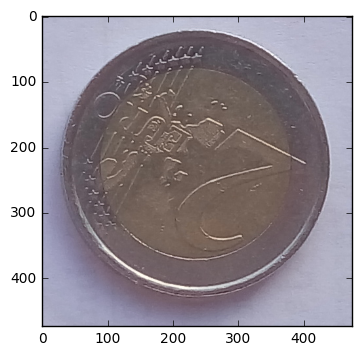

(474, 474, 3)


In [2]:
#Given one coing image, the goal is to create replicas of the same image under different transformations.
test_img= copy.deepcopy(candidates[2])
plt.imshow(test_img)
plt.show()
print test_img.shape

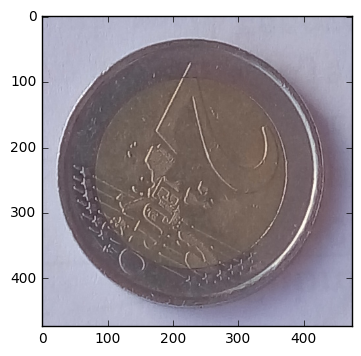

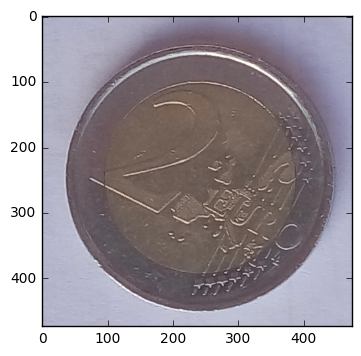

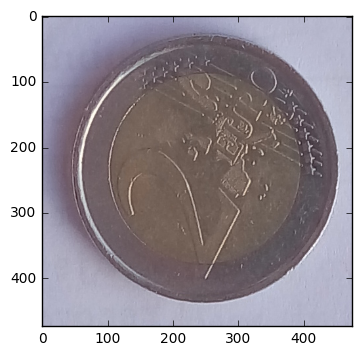

In [3]:
#Rotations
from imutils import rotate
angles = [90,180,270]
for kAngle in angles:
    rotated_image = rotate(test_img, kAngle)   
    plt.imshow(rotated_image)
    plt.show()

# What should be the optimal resolution for training?

(474, 474, 3)


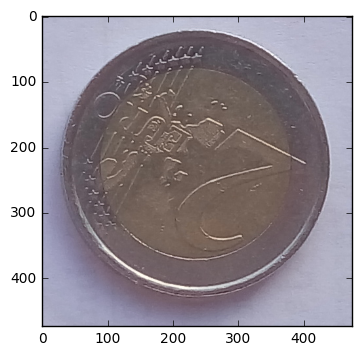

(237, 237, 3)


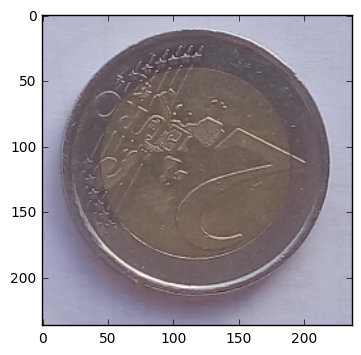

(158, 158, 3)


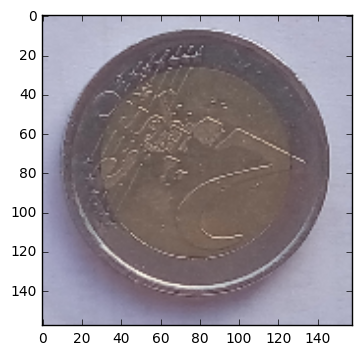

(118, 118, 3)


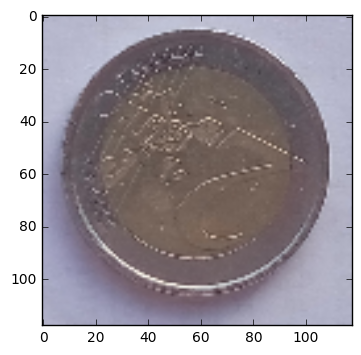

(94, 94, 3)


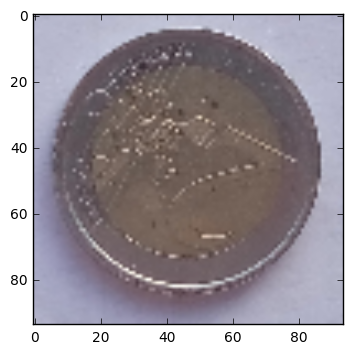

(79, 79, 3)


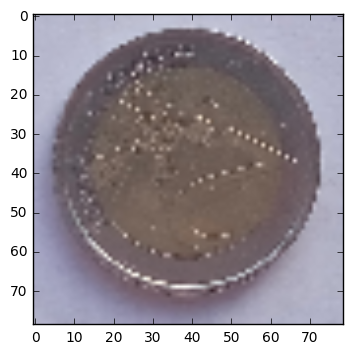

(67, 67, 3)


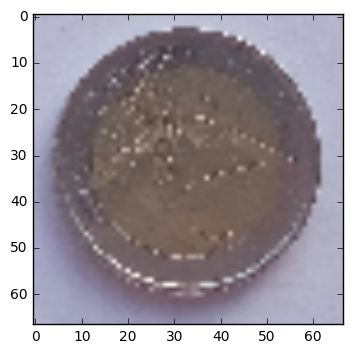

(59, 59, 3)


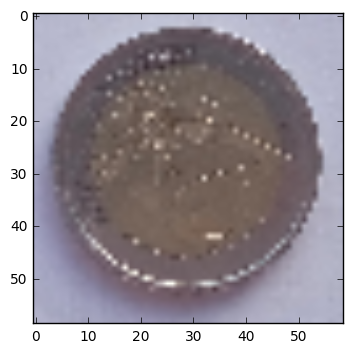

(52, 52, 3)


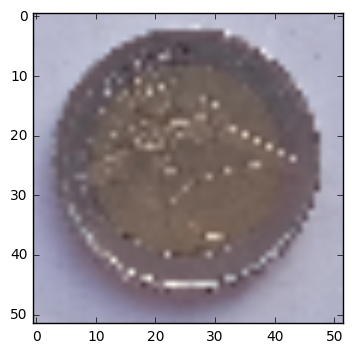

In [4]:
#playing with resolution
for i in range(1,10):
    showInformation(cv2.resize(test_img, (int(test_img.shape[1]/i),int(test_img.shape[0]/i)), interpolation=cv2.INTER_CUBIC))